In [52]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, ReLU, Conv2DTranspose, LeakyReLU, Conv1D
from tensorflow.keras.activations import tanh, sigmoid, relu, softmax

# import librosa # 음성데이터 다루는 라이브러리
# import librosa.display

# Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'wavenet'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'toy_data'
assert dataset_name in ['toy_data'] #['toy_data'] 안에 있는 성분들을 dataset_name으로 선언한다.

max_epochs = 10
save_model_epochs = 1
print_steps = 1
save_images_epochs = 1
batch_size = 1#128
learning_rate = 5e-2
num_examples_to_generate = 16
MNIST_SIZE = 28
hidden_dims = 500

In [12]:
# Load training and eval data from tf.keras
dataset_name = 'toy_data'
N = 10
T = 5
if dataset_name == 'toy_data':
    x = np.array(range(T))
    n = np.random.random(N)*T/2
    train_sequence = np.array([np.sin(x*i/T) for i in n])
 #   target_seqence 쪼개기

train_sequence = np.expand_dims(train_sequence, axis=-1)

In [13]:
#tf.random.set_seed(219)

# for train
N = len(train_sequence)
train_dataset = tf.data.Dataset.from_tensor_slices(train_sequence)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: (1, 5, 1), types: tf.float64>


In [60]:
class kLayers(tf.keras.Model):
    def __init__(self, kernel, Dilation):
        super().__init__() 
    
        self.conv_tanh = Conv1D(1, kernel, padding='causal',
                         dilation_rate=Dilation,
                         activation='tanh')
        self.conv_sig = Conv1D(1, kernel, padding='causal',
                         dilation_rate=Dilation,
                         activation='sigmoid')
        self.conv1x1 = Conv1D(1, 1, padding='same',
                         bias_initializer=tf.keras.initializers.zeros)
    
    def call(self, input_tensor):
        
        output_tanh = self.conv_tanh(input_tensor)
        output_sig = self.conv_sig(input_tensor)
        conv_act_mul = output_tanh*output_sig#element_wise multiplication
        conv_act_mul_conv = self.conv1x1(conv_act_mul) # 1x1 conv
        conv_act_mul_conv_Residual = conv_act_mul_conv + input_tensor #residual
        
        return conv_act_mul_conv, conv_act_mul_conv_Residual

In [83]:
class WaveNet(tf.keras.Model):
    def __init__(self, kernel_size):
        super().__init__() 
    
        self.layer1 = kLayers(kernel=kernel_size, Dilation=1)
        self.layer2 = kLayers(kernel=kernel_size, Dilation=2)
        self.layer3 = kLayers(kernel=kernel_size, Dilation=4)
        self.layer4 = kLayers(kernel=kernel_size, Dilation=8)

        self.conv1x1_relu = Conv1D(1, 1, padding='same', activation='relu')
        self.conv1x1_softmax = Conv1D(1, 1, padding='same')#, activation='softmax')


    def call(self, input_tensor):
        skip1, layer_output = self.layer1(sequence)
        skip2, layer_output = self.layer2(layer_output)
        skip3, layer_output = self.layer3(layer_output)
        skip4, layer_output = self.layer4(layer_output)

        x = relu(skip1 + skip2 + skip3 + skip4)
        x = self.conv1x1_relu(x)
        output = self.conv1x1_softmax(x)

        return output

In [81]:
# companding function #여기 짜보기
# f(x) = sign(x)*log(1+mu*tf.math.ab(x)+epsilon)/log(1+mu+epsilon)
def f(x, mu=255, epsilon = 1e-6):
    return tf.math.sign(x)*tf.math.log(1+mu*tf.math.abs(x)+epsilon)/tf.math.log(1+mu+epsilon).numpy()
    

In [84]:
for sequence in train_dataset.take(1):
    pass
wave = WaveNet(kernel_size=3)
wave(f(sequence)) # f(x) : companding function

<tf.Tensor: id=6942, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.]]])>

-----
-----

In [62]:
# input_ = [batch, 100, 1]

kernel_size = 3
for sequence in train_dataset.take(1):
  pass
layer1 = kLayers(kernel=kernel_size, Dilation=1)
layer2 = kLayers(kernel=kernel_size, Dilation=2)
layer3 = kLayers(kernel=kernel_size, Dilation=4)
layer4 = kLayers(kernel=kernel_size, Dilation=8)

conv1x1_relu = Conv1D(1, 1, padding='same', activation='relu')
conv1x1_softmax = Conv1D(1, 1, padding='same')#, activation='softmax')

skip1, layer_output = layer1(sequence)
skip2, layer_output = layer2(layer_output)
skip3, layer_output = layer3(layer_output)
skip4, layer_output = layer4(layer_output)

x = relu(skip1 + skip2 + skip3 + skip4)
x = conv1x1_relu(x)
output = conv1x1_softmax(x)
output

<tf.Tensor: id=5645, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.],
        [0.],
        [0.],
        [0.],
        [0.]]])>

In [15]:
for sequence in train_dataset.take(1):
  pass
conv0 = Conv1D(1, 3, padding='causal',
                     dilation_rate=1,
                     bias_initializer=tf.keras.initializers.zeros)
conv1 = Conv1D(1, 3, padding='causal',
                     dilation_rate=2,
                     bias_initializer=tf.keras.initializers.zeros)
conv2 = Conv1D(1, 3, padding='causal',
                     dilation_rate=4,
                     bias_initializer=tf.keras.initializers.zeros)
conv3 = Conv1D(1, 3, padding='causal',
                     dilation_rate=8,
                     bias_initializer=tf.keras.initializers.zeros)

In [37]:
kernel=3
Dilation=2

for sequence in train_dataset.take(1):
  pass

conv = Conv1D(1, kernel, padding='causal',
                     dilation_rate=Dilation,
                     bias_initializer=tf.keras.initializers.zeros)
conv_OnebyOne = Conv1D(1, 1, padding='same',
                     bias_initializer=tf.keras.initializers.zeros)

output = conv(sequence)
conv_act_mul = tf.math.multiply(sigmoid(output),tanh(output))
conv_act_mul_conv = conv_OnebyOne(conv_act_mul)
conv_act_mul_conv_Residual = conv_act_mul_conv + output
conv_act_mul_conv_Residual

<tf.Tensor: id=644, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.        ],
        [0.00346603],
        [0.0069348 ],
        [0.01337031],
        [0.01981509]]])>

In [34]:
conv_act_mul

<tf.Tensor: id=324, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.        ],
        [0.00055617],
        [0.00220902],
        [0.00245901],
        [0.00270909]]])>

In [32]:
conv_act_mul.numpy()

array([[[0.        ],
        [0.00055617],
        [0.00220902],
        [0.00245901],
        [0.00270909]]])

In [17]:
sequence.numpy()

array([[[0.        ],
        [0.00392116],
        [0.00784226],
        [0.01176324],
        [0.01568403]]])

In [27]:
output = conv0(sequence)
output.numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: id=307, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.        ],
        [0.00111173],
        [0.00440834],
        [0.00490602],
        [0.00540363]]])>>

In [28]:
sigmoid(output)

<tf.Tensor: id=309, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.5       ],
        [0.50027793],
        [0.50110208],
        [0.5012265 ],
        [0.5013509 ]]])>

In [29]:
tanh(output)

<tf.Tensor: id=311, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.        ],
        [0.00111173],
        [0.00440832],
        [0.00490598],
        [0.00540358]]])>

In [30]:
tf.math.multiply(sigmoid(output),tanh(output))

<tf.Tensor: id=315, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.        ],
        [0.00055617],
        [0.00220902],
        [0.00245901],
        [0.00270909]]])>

In [20]:
output2 = conv1(output1)
output2.numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: id=187, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.        ],
        [0.00069645],
        [0.00276165],
        [0.00265821],
        [0.00173867]]])>>

In [21]:
output3 = conv2(output2)
output3.numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: id=239, shape=(1, 5, 1), dtype=float64, numpy=
array([[[0.        ],
        [0.00043029],
        [0.00170624],
        [0.00164233],
        [0.00107421]]])>>

In [22]:
output4 = conv3(output3)
output4.numpy

<bound method _EagerTensorBase.numpy of <tf.Tensor: id=291, shape=(1, 5, 1), dtype=float64, numpy=
array([[[ 0.        ],
        [-0.00028953],
        [-0.00114808],
        [-0.00110508],
        [-0.0007228 ]]])>>

-----

In [39]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

# sys.path.append(os.path.dirname(os.path.abspath('.')))
# from utils.image_utils import *
# from utils.ops import *

# os.environ["CUDA_VISIBLE_DEVICES"]="0"

ModuleNotFoundError: No module named 'utils'

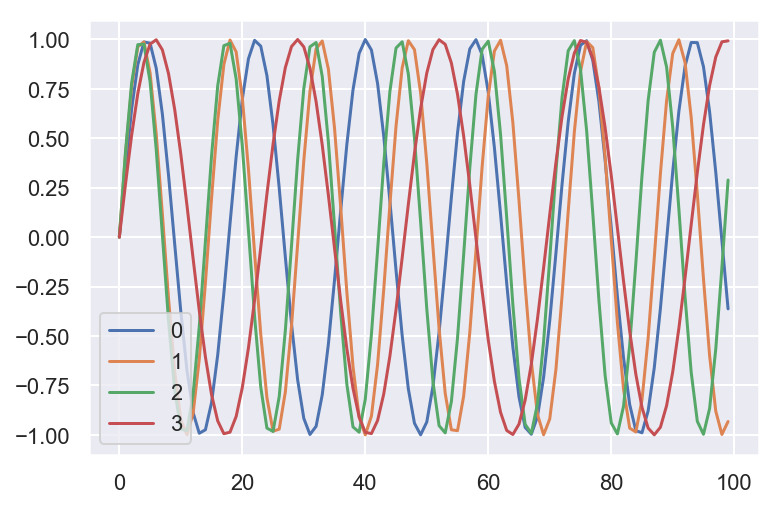

In [24]:
plt.plot(x,train_sequence[0], label='0')
plt.plot(x,train_sequence[1], label='1')
plt.plot(x,train_sequence[2], label='2')
plt.plot(x,train_sequence[3], label='3')
plt.legend(loc=0)
plt.show()

In [25]:
np.squeeze(output.numpy())
padding = 'causal'

NameError: name 'output' is not defined

In [13]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])